In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
from sdhk import SDHKHarvester

In [2]:
sdhk_path = os.path.expanduser("~/Data/SDHK")
assert os.path.exists(sdhk_path)

lowdef_path = os.path.join(sdhk_path, "LowDef")
highdef_path = os.path.join(sdhk_path, "HighDef_png")
savefile = os.path.join(sdhk_path, "metadata.json.gz")
harvester = SDHKHarvester(savefile)

#### Popluate

In [3]:
dl_keys = list(set(range(1, 50000)).difference(set(harvester.keys())))
harvester.download(dl_keys)
print("%i good ids in database" % (len(harvester.get_good_ids())))
print("%i text entries in database" %
      (np.sum([harvester[n]['textcontent'] is not None
       and len(harvester[n]['textcontent']) > 50
       for n in harvester.get_good_ids()])))
harvester.save()

41262 good ids in database
10974 text entries in database


#### Clean up some paths

In [4]:
print("%i bad paths removed form database" % harvester.remove_bad_paths())
if os.path.exists(lowdef_path):
    harvester.scan_lowdef_path(lowdef_path)
print("%i low def images in database" %
      (np.sum(['lowdefpath' in harvester[n]
               for n in harvester.get_good_ids()])))
if os.path.exists(highdef_path):
    harvester.scan_highdef_path(highdef_path)
print("%i high def images in database" %
      (np.sum(['highdefpath' in harvester[n]
               for n in harvester.get_good_ids()])))
harvester.save()

# https://lbiiif.riksarkivet.se/sdhk!1094/manifest

0 bad paths removed form database
11368 low def images in database
11092 high def images in database


#### Write a CSV version of the harvested data

In [5]:
csvfile = savefile.replace(".json.gz", ".csv.gz")
keys = list()
for n in harvester.keys():
    for k in harvester[n].keys():
        if k not in keys:
            keys.append(k)

import gzip
with gzip.open(csvfile, 'wt') as f:
    for i, k in enumerate(keys):
        if i >  0:
            f.write(", ")
        f.write(k)
    f.write('\n')
    for n in harvester.keys():
        for i, k in enumerate(keys):
            if k in harvester[n].keys():
                if i >  0:
                    f.write(", ")
                data = harvester[n][k]
                if type(data) == str:
                    f.write('\"' + data + '\"')
                else:
                    f.write(repr(data))
        f.write('\n')

#### Plot histogram over text length and entries per decade

/home/fredrik/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


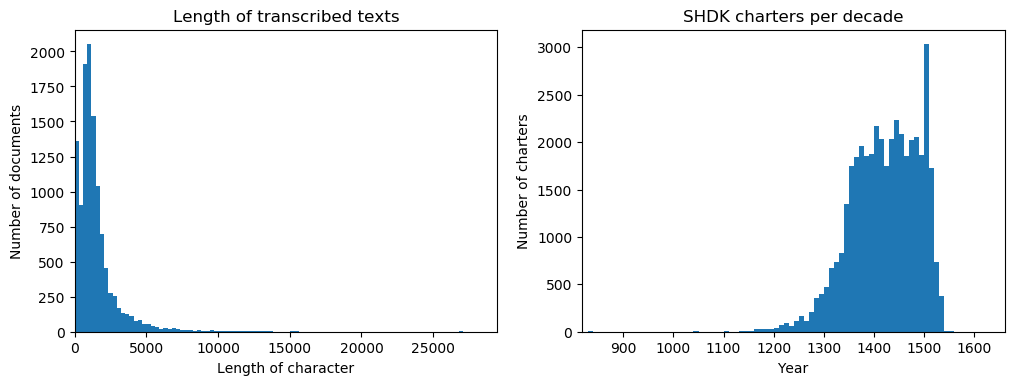

In [6]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.subplots(1, 2)
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

text_ids = [n for n in harvester.get_good_ids()
            if harvester[n]['textcontent'] is not None]
text_lengths = [len(harvester[n]['textcontent']) for n in text_ids]

ax[0].set_title("Length of transcribed texts")
ax[0].hist(text_lengths, 100)
ax[0].set_xlabel('Length of character')
ax[0].set_ylabel('Number of documents')
ax[0].set_xlim(np.min(text_lengths), np.max(text_lengths))

dated_ids = [n for n in harvester.get_good_ids()
             if 0 < harvester[n]['year'] and
             harvester[n]['year'] <= 1661]
years = [harvester[n]['year'] for n in dated_ids]

ax[1].set_title("SHDK charters per decade")
ax[1].hist(years, list(range(np.min(years)//10*10, np.max(years)//10*10, 10)))
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of charters')
ax[1].set_xlim(np.min(years), np.max(years))
#ax[1].set_xlim(1135, 1546)

fig.show()

#### Plot months

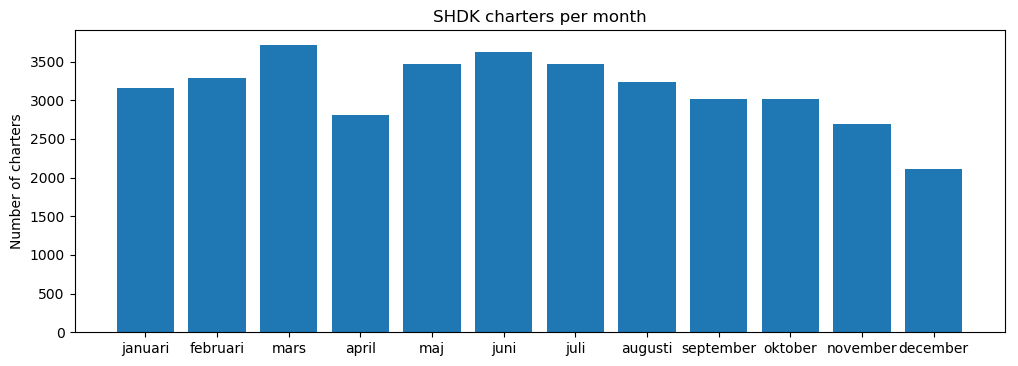

In [7]:
dates_as_text = [harvester[n]['date_as_text'].lower() for n in harvester.keys() if 'date_as_text' in harvester[n]]

months = ['januari', 'februari', 'mars', 'april', 'maj', 'juni', 'juli', 
          'augusti', 'september', 'oktober', 'november', 'december']

def get_date_tuple(text):
    try:
        t = text.split(" ")
        assert len(t) == 3
        year = int(t[0])
        day = int(t[2])
        for i, m in enumerate(months):
            if t[1].find(m) >= 0:
                return (year, i+1, day)
        return None
    except:
        return None

assert get_date_tuple('1373 oktober 25')[0] == 1373
assert get_date_tuple('1373 oktober 25')[1] == 10
assert get_date_tuple('1373 oktober 25')[2] == 25
assert get_date_tuple('1409 november 5')[0] == 1409
assert get_date_tuple('1409 november 5')[1] == 11
assert get_date_tuple('1409 november 5')[2] == 5
assert get_date_tuple('1373utan dag') is None

month = [date[1] for date in list(map(get_date_tuple, dates_as_text)) if date is not None]

month_histogram = np.zeros(len(months))
for i, m in enumerate(months):
    month_histogram[i] = np.sum(np.asarray(month)==(i+1))

fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.subplots(1, 1)
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

bars = ax.bar(list(range(12)), month_histogram)
ax.set_title('SHDK charters per month')
ax.set_ylabel('Number of charters')
ax.set_xticks(list(range(12)))
ax.set_xticklabels(months)

plt.show()

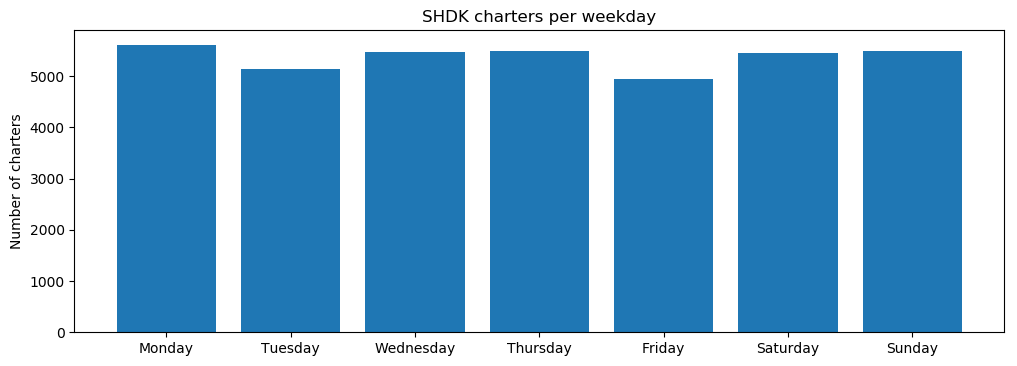

In [8]:
#pip install convertdate
from convertdate import julian
from datetime import date

def to_gregorian_weekday(date_tuple):
    try:
        j = julian.to_gregorian(date_tuple[0], date_tuple[1], date_tuple[2])
        ret = date(j[0], j[1], j[2]).weekday()
        return ret
    except:
        return None

date_tuples = [date_tuple for date_tuple in list(map(get_date_tuple, dates_as_text)) if date_tuple is not None]
weekdays = [weekday for weekday in list(map(to_gregorian_weekday, date_tuples)) if weekday is not None]
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_histogram = np.zeros(len(weekday_names))
for weekday in weekdays:
    weekday_histogram[weekday] += 1

fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.subplots(1, 1)
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

ax.bar(list(range(7)), weekday_histogram)
ax.set_title('SHDK charters per weekday')
ax.set_ylabel('Number of charters')
ax.set_xticks(list(range(7)))
ax.set_xticklabels(weekday_names)

plt.show()